In [1]:
import cv2
import numpy as np
import math
import sympy as sym
import matplotlib.pyplot as plt
from scipy import signal 
import matplotlib.pyplot as plt   # MATLAB plotting functions
from control.matlab import *  # MATLAB-like functions

In [2]:
class Point:
    RADIUS = 5  # Global radius for all points

    def __init__(self, x_or_iterable, y=None):
        if isinstance(x_or_iterable, tuple):
            x, y = x_or_iterable
        elif hasattr(x_or_iterable, '__iter__'):
            x, y = x_or_iterable
        else:
            x, y = x_or_iterable, y
        self.x = int(x)
        self.y = int(y)
    def __iter__(self):
        return iter(self.__dict__.values())
    def draw(self, img, color=(255, 255, 255), thickness=-1):
        cv2.circle(imfullSys, (self.x, self.y), Point.RADIUS, color, thickness)

class Vector:
    def __init__(self, start, end, thickness=2, colormap=None,idx=0):
        self.start = start
        self.end = end
        self.thickness = thickness
        self.colormap = colormap
        self.idx = idx

    def draw(self, img):
        if self.colormap is None:
            color = (0, 255, 0)
        else:
            color = self.colormap(self.idx)
        cv2.arrowedLine(img, (self.start.x, self.start.y), (self.end.x, self.end.y), color, self.thickness)

def num_points_colormap(num_points,max_num_points=10):
    """
    A colormap that maps the number of points to a color.
    Fewer points are blue, more points are red.
    """
    
    r = min(255, int(num_points / max_num_points * 255))
    b = max(0, 255 - r)
    return (b, 0, r)

In [3]:
def motorPlant(velocities:tuple,ref:tuple,sampleRate = 1)->tuple:
    xdist,ydist = ref
    distance_between_motors = 10 #cm
    vl,vr = velocities
    phi = (vr-vl)/distance_between_motors
    # Calculate forward velocity
    v = (vl + vr) 
    print(v)
    xdot =v * math.sin(phi *sampleRate / 2) 
    ydot =v * math.cos(phi * sampleRate/ 2) 
    print(f"")
    xbar =  xdist - xdot * sampleRate #  new x
    ybar = ydist - ydot * sampleRate #new y
    print(f"x:{xdist} y:{ydist}|Xdot: {xdot} Ydot:{ydot} |xbar : {xbar} ybar:{ybar}")
    return (xbar,ybar)


In [4]:
def motorPlant_tf():
    # Define Laplace variable
    s = sym.symbols('s')
    # xdot = v  * (phi*sampleRate/2)
    # ydot = v * 1-((phi*sampleRate/2)**2)/2
    # xbar = xdist - xdot *sampleRate =  x - v  * (phi*sampleRate/2)
    # xbar = x - v * (dv/c * sr) => Xbar = X - XdotS => Y= U - Ys => Y(1-s) = U=> Y/U = 1/(1-s)
    # Define transfer function
    num = [1]
    den = [1,-1]
    tf = TransferFunction(num,den)
    return tf


In [5]:
SCALE = 2
IMG_WIDTH = 300 * SCALE
IMG_HEIGHT = 300 *SCALE
XDIST = -10 *SCALE
YDIST = 110 *SCALE
start = (XDIST, YDIST)
RATIO = 0.25
SPEED = 1.5
SAMPLE_RATE =10
stepSize = (SPEED*(1-RATIO)*SCALE,SPEED*RATIO*SCALE)
# Create a black image
img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
# Define points as Point objects
centre = Point(IMG_HEIGHT//2, IMG_WIDTH//2)
p2 = Point(centre.x + XDIST, centre.y - YDIST)
# motorPlant((1,1),p2)
x,y = motorPlant(stepSize, start,sampleRate=SAMPLE_RATE)
newPoint = Point(centre.x+x,centre.y-y)
points = [centre,p2,newPoint]
vectors = [Vector(centre, p2, colormap=num_points_colormap, thickness=2,idx=0),
           Vector(centre,newPoint,colormap=num_points_colormap, thickness=2,idx=1)]

for i in range(2,10):
    x,y = motorPlant(stepSize, (x,y),sampleRate=SAMPLE_RATE)
    newPoint = Point(centre.x+x,centre.y-y)
    points.append(newPoint)
    vectors.append(Vector(centre, newPoint, colormap=num_points_colormap, thickness=2,idx=i))


    # Draw the points and vectors on the image
    for point in points:
        point.draw(img)

    for vector in vectors:
        vector.draw(img)

    # Display the image
    cv2.imshow('Points and Vectors', img)
cv2.waitKey(0)
cv2.destroyAllWindows()



3.0

x:-20 y:220|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 0.449162800700023 ybar:198.04933393378536
3.0

x:0.449162800700023 y:198.04933393378536|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 20.898325601400046 ybar:176.09866786757073
3.0

x:20.898325601400046 y:176.09866786757073|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 41.34748840210007 ybar:154.1480018013561
3.0

x:41.34748840210007 y:154.1480018013561|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 61.79665120280009 ybar:132.19733573514145
3.0

x:61.79665120280009 y:132.19733573514145|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 82.24581400350012 ybar:110.24666966892683
3.0

x:82.24581400350012 y:110.24666966892683|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 102.69497680420014 ybar:88.2960036027122
3.0

x:102.69497680420014 y:88.2960036027122|Xdot: -2.0449162800700025 Ydot:2.1950666066214626 |xbar : 123.14413960490016 ybar:66.34533753649758
3.0

x:12

In [6]:
s = sym.Symbol('s')
kp = sym.Symbol('kp')
kd= sym.Symbol('kd')
ki= sym.Symbol('ki')
top = kp -kd*s + ki/s
bottom = s - 1

L = top/bottom
G = L / (1+ L)
num, den = sym.fraction(G)
print("G",sym.simplify(G))
print(sym.expand(sym.simplify(den*s)))
# (1-kd*)s**2 +(kp-1)*s ki + 

#ts = 4/(zeta omega_n)
#tr = (pi - \beta) w_d

G (ki + s*(-kd*s + kp))/(ki + s*(s - 1) + s*(-kd*s + kp))
-kd*s**2 + ki + kp*s + s**2 - s


In [63]:

# tp = sym.pi/wd
def calcParams(overshoot,riseTime,ki):
    zeta = sym.Symbol('zeta')
    wn = sym.Symbol('wn')
    M = sym.exp(-(sym.pi*zeta)/(sym.sqrt(1-zeta**2)))
    # print(M)
    zeta = sym.solve(M-overshoot,zeta)[0]
    wn = 1.8/riseTime
    #2zetawn = kp +1
    # wn^2 = ki/(1+kd)
    print(zeta,wn)
    kp = sym.Symbol('kp')
    kd = sym.Symbol('kd')
    eq1  = 2*zeta*wn - ((kp+1)/(kd+1))
    eq2 = wn**2 - (ki/(kd+1))
    sol = sym.solve([eq1,eq2],[kp,kd])
    print(sol, type(sol))
    kp = float(sol[kp])
    kd = float(sol[kd])
    kd = ki/(wn**2) -1
    return kp,kd,ki



0.455949810769126 2.5714285714285716
{kp: -0.645372369401791, kd: -0.848765432098765} <class 'dict'>
OVERSHOOT:0.2 | RiseTime:0.7 | kp:10 kd:10 ki:1

10 s^2 + 10 s + 1
-----------------
        s


  1
-----
s - 1


10 s^2 + 10 s + 1
-----------------
11 s^2 + 9 s + 1

{'RiseTime': 0.0, 'SettlingTime': 16.895356620048894, 'SettlingMin': 0.9090909090909091, 'SettlingMax': 1.0920505961262577, 'Overshoot': 9.205059612625766, 'Undershoot': 0, 'Peak': 1.0920505961262577, 'PeakTime': 3.620433561439049, 'SteadyStateValue': 1.0}


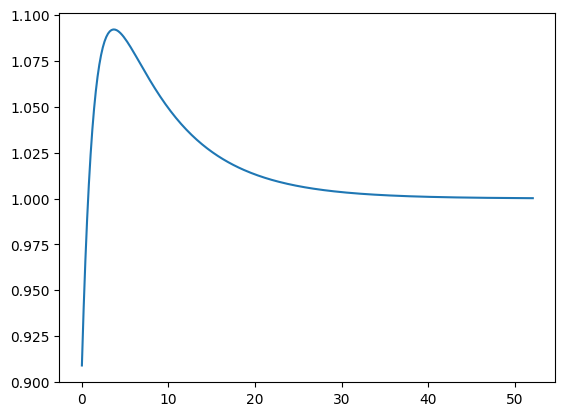

In [69]:
FULL = False
ki=1
overshoot = 0.2
riseTime=0.7
kp,kd,ki = calcParams(overshoot,riseTime,ki)
kp,kd,ki = 10,10,1
print(f"\033[31mOVERSHOOT:{overshoot} | RiseTime:{riseTime} | kp:{kp} kd:{kd} ki:{ki}\033[0m")
pid = TransferFunction([kd,kp,ki],[1,0])

print(pid)
x = motorPlant_tf()
print(x)
L= pid*x 
# print(L)

fullSys = feedback(L,1)
print(fullSys)
#(1-kd*)s**2 +(kp-1)*s ki 
# w^2 = 
# Step response for the system
#omega_n = sqrt(Kp + Ki/Ti)
# zeta = (Kp + Ki/Ti)/(2*omega_n)

plt.figure(1)
print(stepinfo(fullSys))
xout, T = step(fullSys)
# rlocus(fullSys)
plt.plot(T.T, xout.T)
plt.show()
if FULL:
    # Plot the root locus
    rlist, klist = rlocus(fullSys)
    plt.figure()
    plt.title('Root Locus')
    plt.plot(rlist.real, rlist.imag, '-')
    plt.grid(True)

    # Plot the Bode plot
    mag, phase, omega = bode(fullSys)
    plt.figure()
    plt.semilogx(omega, mag)
    plt.semilogx(omega, phase)
    plt.title('Bode Plot')
    plt.legend(('Magnitude', 'Phase'))
    plt.grid(True)

    # Plot the Nyquist plot
    real, imag, freq = nyquist(fullSys, Plot=False)
    plt.figure()
    plt.plot(real, imag)
    plt.title('Nyquist Plot')
    plt.grid(True)

    plt.show()
